In [1]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  merge, relative_frequency, filter_features_conditionally,
                                                 group)

from qiime2.plugins.feature_table.visualizers import summarize

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor
from qiime2.plugins.empress.actions import community_plot

from assets.step_wise_anova import run_stepwise_anova

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re

from statannotations.Annotator import Annotator

In [2]:
# classifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
# stats
from statsmodels.stats.contingency_tables import mcnemar


# CARD

In [ ]:
#CARD 

In [19]:
#list of file directories from CARD output
files_3dmm = pd.read_csv('./metadata/3DMM_files.csv',header=None,
                         names=['sample_name','barcode','r1','r2'])

In [20]:
def read_report_from_file(file_path):
    try:
        # Read the contents of the file
        with open(file_path, 'r') as file:
            report_text = file.read()
        return report_text
    except FileNotFoundError:
        print("Error: File not found.")
        return None


def extract_mapped_reads_percentage(report_text):
    # Define the regular expression pattern to match the percentage of mapped reads
    pattern = r"Mapped reads:\s+\d+\s+\((\d+\.\d+)%\)"
    
    # Search for the pattern in the report text
    match = re.search(pattern, report_text)
    
    if match:
        # Extract the percentage value from the matched group
        percentage = float(match.group(1))
        return percentage
    else:
        return None
    

def extract_total_reads(report_text):
    # Define the regular expression pattern to match the "Total reads" line
    pattern = r"Total reads:\s+(\d+)"
    
    # Search for the pattern in the report text
    match = re.search(pattern, report_text)
    
    if match:
        # Extract the total reads count from the matched group
        total_reads = int(match.group(1))
        return total_reads
    else:
        return None

In [21]:
for sample_name in files_3dmm['barcode']:
    directory_ = f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.overall_mapping_stats.txt'
    report = read_report_from_file(directory_)
    if report is None:
        files_3dmm.loc[files_3dmm['barcode']==sample_name,
                                'AMR_mapped_reads (%)']=np.nan
    else:
        mapped_reads = extract_mapped_reads_percentage(report)
        files_3dmm.loc[files_3dmm['barcode']==sample_name,
                                'AMR_mapped_reads (%)']=mapped_reads

/home/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMR_mapped_reads (%)', ylabel='Density'>

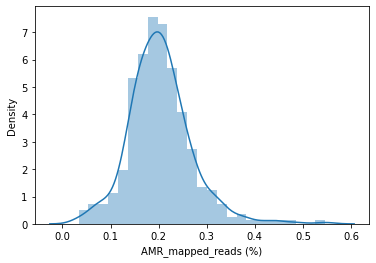

In [22]:
sns.distplot(files_3dmm['AMR_mapped_reads (%)'])

In [23]:
metadata_w_alpha = pd.read_csv('./metadata/alphadiv_16s_w_metadata.csv')
metadata_w_alpha['Unnamed: 0'] = metadata_w_alpha['Unnamed: 0'].str.replace('150297.','').str.replace('151322.','')
metadata_w_alpha.set_index('Unnamed: 0',inplace=True)

In [24]:
files_3dmm_merged  = files_3dmm.merge(metadata_w_alpha,right_index=True,left_on= 'sample_name')

In [25]:
for module in files_3dmm_merged['module'].unique():
    module_median = files_3dmm_merged.loc[files_3dmm_merged['module']==module,'AMR_mapped_reads (%)'].median()
    files_3dmm_merged.loc[files_3dmm_merged['module']==module,'AMR_percent_median'] = module_median

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.681e-01 U_stat=7.930e+02
Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.459e-01 U_stat=3.312e+03
JLP vs. JPM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.059e-05 U_stat=9.200e+01
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.030e-01 U_stat=2.644e+03
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.690e-01 U_stat=6.490e+02
Node 1 vs. Airlock: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.198e-01 U_stat=1.680e+02
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochber

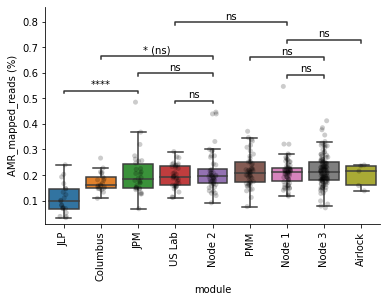

In [26]:
order_ = files_3dmm_merged.sort_values(by='AMR_percent_median')['module'].unique()
#pairs were defined by physical interconnectedness of modules 

ax1 = plt.subplot(111)



sns.boxplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),fliersize=0,ax=ax1)
sns.stripplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),color='black',alpha=0.2,ax=ax1)
plt.xticks(rotation=90)

# ax1.set_ylim(0,0.7)
pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=files_3dmm_merged, x='module', y='AMR_mapped_reads (%)', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)

In [27]:
files_3dmm_merged['AMR_mapped_reads (%)'].describe()

count    384.000000
mean       0.204423
std        0.067346
min        0.033687
25%        0.161430
50%        0.198771
75%        0.236426
max        0.546480
Name: AMR_mapped_reads (%), dtype: float64

In [28]:
round(0.198771, 2)


0.2

In [29]:
module_colors= {'Airlock':'tab:red',
               'Columbus':'tab:blue',
               'JLP':'tab:orange',
               'JPM':'tab:green',
               'US Lab':'cadetblue',
               'Node 1':'tab:purple',
               'Node 2':'yellow',
               'Node 3':'tab:cyan',
               'PMM':'tab:pink'}

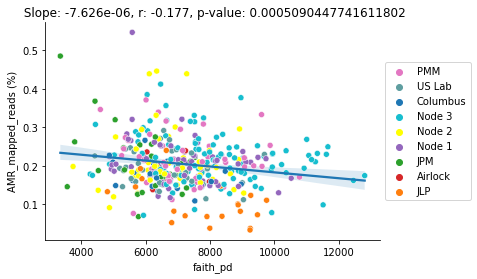

In [30]:
cat_ = 'faith_pd'
ax = plt.subplot(111)
sns.regplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,scatter=False)
sns.scatterplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,hue='module',palette=module_colors)

res = stats.linregress(files_3dmm_merged[cat_],
                       files_3dmm_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
plt.xlabel(cat_)
plt.ylabel('AMR_mapped_reads (%)')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

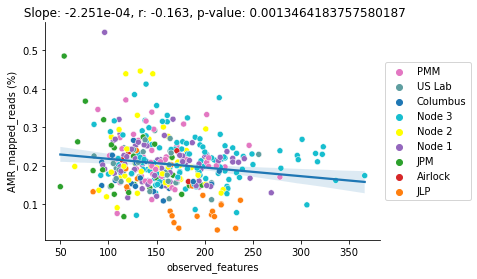

In [31]:
cat_ = 'observed_features'
ax = plt.subplot(111)
sns.regplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,scatter=False)
sns.scatterplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,hue='module',palette=module_colors)

res = stats.linregress(files_3dmm_merged[cat_],
                       files_3dmm_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
plt.xlabel(cat_)
plt.ylabel('AMR_mapped_reads (%)')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [32]:
AMR_mapped_reads = 0
amr_3dmm_df = pd.DataFrame()
amr_metadata_3dmm_df = pd.DataFrame()
for sample_name in files_3dmm['barcode']:
    directory_ = f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.overall_mapping_stats.txt'
    report = read_report_from_file(directory_)
    total_reads = extract_total_reads(report)
    table = pd.read_csv(f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.gene_mapping_data.txt',sep='\t')
    amr_metadata = table[['ARO Term','ARO Accession','Reference Model Type',
                          'Reference DB','Resistomes & Variants: Observed Pathogen(s)',
                          'AMR Gene Family','Drug Class', 'Resistance Mechanism']]
    amr_count_table = table[['ARO Term','All Mapped Reads']].T
    amr_count_table.columns = amr_count_table.loc['ARO Term']
    amr_count_table.columns.name=None
    amr_count_table.index.name = 'sample_name'
    amr_count_table.drop(index='ARO Term',inplace=True)
    amr_count_table.rename(index={'All Mapped Reads':sample_name},inplace=True)
    AMR_mapped_reads += int(amr_count_table.sum(axis=1))
    amr_count_table = amr_count_table/total_reads
    amr_3dmm_df = pd.concat([amr_3dmm_df,amr_count_table])
    amr_metadata_3dmm_df = pd.concat([amr_metadata_3dmm_df,amr_metadata])
amr_metadata_3dmm_df = amr_metadata_3dmm_df.set_index('ARO Term')
amr_metadata_3dmm_df = amr_metadata_3dmm_df[~amr_metadata_3dmm_df.index.duplicated(keep='first')]

/tmp/ipykernel_49253/933990368.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  amr_3dmm_df = pd.concat([amr_3dmm_df,amr_count_table])


In [33]:
f"{AMR_mapped_reads:.2e}"

'4.70e+06'

In [34]:
AMR_mapped_reads

4698656

In [35]:
AMR_mapped_reads / 5.27e9 *100

0.08915855787476282

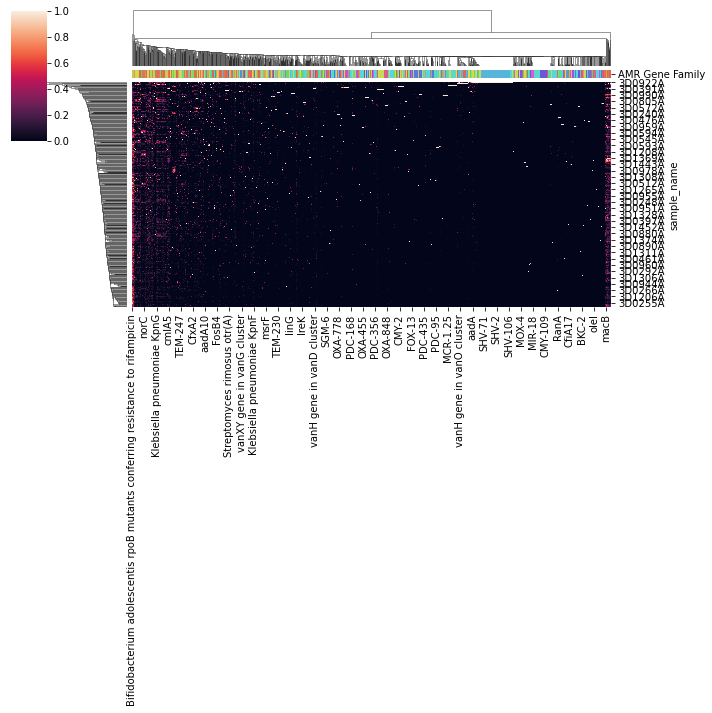

In [36]:
lut = dict(zip(amr_metadata_3dmm_df['AMR Gene Family'].unique(),
               sns.hls_palette(len(set(amr_metadata_3dmm_df['AMR Gene Family'])))))
col_colors = amr_metadata_3dmm_df['AMR Gene Family'].map(lut)
sns.clustermap(amr_3dmm_df.fillna(0),standard_scale=1,col_colors=col_colors)

In [37]:
print(f"{len(set(amr_3dmm_df.columns))} number of unique columns")
print(f"{len(set(amr_3dmm_df.index))} number of unique samples")

1065 number of unique columns
393 number of unique samples


In [38]:
amr_3dmm_df.shape

(393, 1065)

In [39]:
amr_3dmm_df.sum(axis=1)

sample_name
3D0416A    0.003296
3D0245A    0.003144
3D1004A    0.001872
3D0203A    0.002396
3D0492A    0.001861
             ...   
3D1356A    0.003520
3D0207A    0.001672
3D0248A    0.003317
3D1311A    0.002448
3D0854A    0.001219
Length: 393, dtype: float64

In [40]:
ft_df = pd.DataFrame(amr_3dmm_df.sum(axis=1),columns=['%'])

ft_df_merged = ft_df.merge(files_3dmm_merged,left_index=True, right_on='barcode_x')
ft_df_merged['%'] = ft_df_merged['%'] * 100 #to turn into %

<AxesSubplot:title={'center':' Slope: 7.924e-01, r: 0.994, p-value: 0.0'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

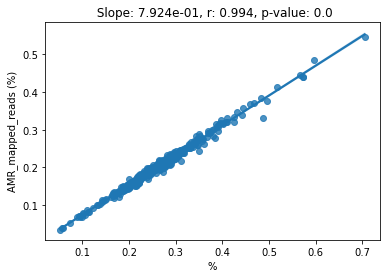

In [41]:
res = stats.linregress(ft_df_merged['%'],
                       ft_df_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=ft_df_merged)

In [42]:
amr_3dmm_ft = amr_3dmm_df.merge(metadata_df[['tube_barcode']],left_index=True,right_on='tube_barcode')
amr_3dmm_ft.drop(columns='tube_barcode',inplace=True)

In [43]:
amr_3dmm_ft.shape

(393, 1065)

In [44]:
amr_3dmm_ft = amr_3dmm_ft.drop_duplicates()

In [45]:
amr_3dmm_ft.shape

(393, 1065)

In [46]:
len(set(amr_3dmm_ft.columns))

1065

In [47]:
for sample in amr_3dmm_ft.index:
    amr_n =sum(amr_3dmm_ft.loc[sample]>0)
    amr_3dmm_ft.loc[sample,'AMR gene count']=amr_n


In [48]:
amr_3dmm_ft['AMR gene count'].describe()

count    393.000000
mean     111.346056
std       47.475475
min       33.000000
25%       77.000000
50%       99.000000
75%      142.000000
max      357.000000
Name: AMR gene count, dtype: float64

/home/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMR gene count', ylabel='Density'>

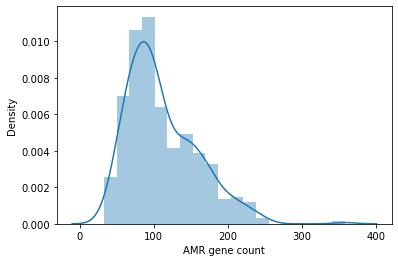

In [49]:
sns.distplot(amr_3dmm_ft['AMR gene count'])

In [50]:
#introduce "Other" genes column to add relative abundances up to 1
amr_3dmm_ft['other'] = 1 - amr_3dmm_ft.sum(1)

In [51]:
amr_metadata_3dmm_df

,ARO Accession,Reference Model Type,Reference DB,Resistomes & Variants: Observed Pathogen(s),AMR Gene Family,Drug Class,Resistance Mechanism
ARO Term,,,,,,,
srmB,3002828,protein homolog model,CARD,Streptomyces ambofaciens,Miscellaneous ABC-F subfamily ATP-binding cass...,macrolide antibiotic,antibiotic target protection
vgaALC,3002830,protein homolog model,CARD; Resistomes & Variants,Staphylococcus haemolyticus; Enterobacter horm...,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection
mtrE,3000812,protein homolog model,CARD,Neisseria gonorrhoeae,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; penam,antibiotic efflux
macB,3000535,protein homolog model,CARD; Resistomes & Variants,Neisseria gonorrhoeae,ATP-binding cassette (ABC) antibiotic efflux pump,macrolide antibiotic,antibiotic efflux
vgaA,3002829,protein homolog model,CARD,Staphylococcus aureus,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection
...,...,...,...,...,...,...,...
SHV-225,3005241,protein homolog model,Resistomes & Variants,Klebsiella pneumoniae,SHV beta-lactamase,carbapenem; cephalosporin; penam,antibiotic inactivation
aadA4,3002604,protein homolog model,Resistomes & Variants,Salmonella enterica,ANT(3''),aminoglycoside antibiotic,antibiotic inactivation
aadA12,3002612,protein homolog model,Resistomes & Variants,Pseudomonas aeruginosa,ANT(3''),aminoglycoside antibiotic,antibiotic inactivation


In [52]:
def find_substring_in_tuple(my_tuple, substring):
    # Iterate over each item in the tuple
    for item in my_tuple:
        # Check if the substring is in the current item
        if substring in item:
            # If found, return the item
            return item
    # If the substring is not found, return None or an appropriate message
    return None

megares_mapper_df = pd.read_csv('./metadata/megares_to_external_header_mappings_v3.00.csv')
megares_mapper_df = megares_mapper_df.loc[megares_mapper_df['Database']=='CARD']
mapping_df = pd.DataFrame(columns=['ARO', 'MEG', 'AMR class'],dtype=object)
for index, row in megares_mapper_df.iterrows():
    tuple_ =  row['Source_header'].split('|')
    ARO = find_substring_in_tuple(tuple_, 'ARO')
    ARO_match = ARO.split(':')[1]
    MEG_match =  row['MEGARes_header'].split('|')[0]
    AMR_class =  row['MEGARes_header'].split('|')[2]
    append_row = pd.Series([ARO_match,MEG_match,AMR_class],
                           index=['ARO','MEG', 'AMR class'])
    mapping_df = mapping_df.append(append_row,ignore_index=True)
mapping_df
    

,ARO,MEG,AMR class
0,3003485,MEG_1,Aminoglycosides
1,3003512,MEG_2,Aminoglycosides
2,3003481,MEG_3,Aminoglycosides
3,3003495,MEG_4,Aminoglycosides
4,3003240,MEG_5,Aminoglycosides
...,...,...,...
3278,3005520,MEG_8737,betalactams
3279,3005521,MEG_8738,betalactams
3280,3005040,MEG_8741,Drug_and_biocide_resistance
3281,3007005,MEG_8742,betalactams


/home/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Aminoglycosides'),
  Text(1, 0, 'Fosfomycin'),
  Text(2, 0, 'Multi-drug_resistance'),
  Text(3, 0, 'betalactams'),
  Text(4, 0, 'Drug_and_biocide_resistance'),
  Text(5, 0, 'Cationic_antimicrobial_peptides'),
  Text(6, 0, 'Rifampin'),
  Text(7, 0, 'Bacitracin'),
  Text(8, 0, 'Glycopeptides'),
  Text(9, 0, 'Phenicol'),
  Text(10, 0, 'Lipopeptides'),
  Text(11, 0, 'MLS'),
  Text(12, 0, 'Drug_and_biocide_and_metal_resistance'),
  Text(13, 0, 'Fluoroquinolones'),
  Text(14, 0, 'Trimethoprim'),
  Text(15, 0, 'Mycobacterium_tuberculosis-specific_Drug'),
  Text(16, 0, 'Phenolic_compound_resistance'),
  Text(17, 0, 'Elfamycins'),
  Text(18, 0, 'Sulfonamides'),
  Text(19, 0, 'Fusidic_acid'),
  Text(20, 0, 'Aminocoumarins'),
  Text(21, 0, 'Mupirocin'),
  Text(22, 0, 'Oxazolidinone'),
  Text(23, 0, 'Tetracyclines'),
  Text(24, 0, 'Pactamycin'),
  

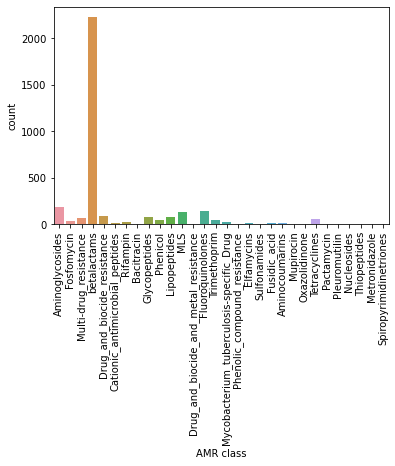

In [53]:
sns.countplot(mapping_df['AMR class'])
plt.xticks(rotation=90)
#plt.yscale('log')

In [57]:
amr_megares_mapped = amr_3dmm_ft.T.merge(amr_metadata_3dmm_df[['ARO Accession','Reference DB']].astype(str),left_index=True,right_index=True)
amr_megares_mapped = amr_megares_mapped.set_index('ARO Accession')
amr_megares_mapped = amr_megares_mapped.merge(mapping_df.astype(str),left_index=True,right_on='ARO')
amr_megares_mapped.set_index('ARO',inplace=True)
amr_megares_mapped.drop(columns = ['Reference DB','MEG','AMR class'],inplace=True)
amr_megares_mapped = amr_megares_mapped.T
amr_megares_mapped.index.names = ['sample_name']

# removes duplicate observations 
amr_megares_mapped = amr_megares_mapped.loc[:,~amr_megares_mapped.columns.duplicated(keep='first')]
amr_megares_mapped = amr_megares_mapped.loc[~amr_megares_mapped.index.duplicated(keep='first')]

In [58]:
mapping_metadata = mapping_df.set_index('ARO')
mapping_metadata.rename(columns={'AMR class':'Taxon'},inplace=True)
mapping_metadata.index.names = ['Feature ID']
mapping_metadata = mapping_metadata[~mapping_metadata.index.duplicated(keep='first')]

In [59]:
mapping_df.loc[mapping_df['AMR class']=='Rifampin']['ARO']

278     3002846
279     3002847
280     3002849
281     3002850
282     3002848
283     3002852
284     3002853
1019    3002884
1983    3000245
1996    3000444
1997    3003992
1998    3003283
1999    3003284
2000    3000501
2001    3004480
2002    3003288
2003    3004563
3236    3007051
3237    3004480
Name: ARO, dtype: object

In [60]:
3004480

3004480

In [61]:
amr_megares_mapped.loc[:,amr_megares_mapped.columns.isin(mapping_df.loc[mapping_df['AMR class']=='Rifampin']['ARO'])].sum().sort_values()

ARO
3002847    2.573723e-07
3003992    2.336809e-06
3002884    1.378263e-05
3002846    3.667469e-05
3002848    9.428876e-05
3000444    1.567877e-04
3000245    2.604967e-03
3000501    3.460388e-02
3004480    1.738620e-01
dtype: float64

In [62]:
megares_mapper_df

,Database,Source_header,MEGARes_header,UpdatedHeader
0,CARD,CARD|gb|AB001778.1|+|0-1507|ARO:3003485|Chlamy...,MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...,NaN
1,CARD,CARD|gb|AE006468|+|3570463-3572006|ARO:3003512...,MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...,NaN
2,CARD,CARD|gb|AL123456.3|+|1471846-1473382|ARO:30034...,MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...,NaN
3,CARD,CARD|gb|CP020418|+|383737-385288|ARO:3003495|N...,MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...,NaN
4,CARD,CARD|gb|CU458896.1|+|1462398-1463901|ARO:30032...,MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...,NaN
...,...,...,...,...
8736,CARD,gb|NG_070756.1|+|1-801|ARO:3005520|VIM-72,MEG_8737|Drugs|betalactams|Class_B_betalactama...,NaN
8737,CARD,gb|NG_070757.1|+|1-801|ARO:3005521|VIM-73,MEG_8738|Drugs|betalactams|Class_B_betalactama...,NaN
8740,CARD,gb|VAOQ01003483.1|+|0-339|ARO:3005040|YajC,MEG_8741|Multi-compound|Drug_and_biocide_resis...,NaN
8741,CARD,gb|NG_070759.1|+|101-841|ARO:3007005|YEM-1,MEG_8742|Drugs|betalactams|Class_B_betalactama...,NaN


In [63]:
list(megares_mapper_df.loc[megares_mapper_df['Source_header'].str.contains('ARO:3004480')]['MEGARes_header'])

['MEG_6093|Drugs|Rifampin|Rifampin-resistant_beta-subunit_of_RNA_polymerase_RpoB|RPOB|RequiresSNPConfirmation',
 'MEG_8674|Drugs|Rifampin|Rifampin-resistant_beta-subunit_of_RNA_polymerase_RpoB|RPOB']

In [64]:
megares_check = pd.DataFrame(amr_megares_mapped.sum(axis=1),columns=['%'])

In [65]:
megares_check_merged = megares_check.merge(files_3dmm_merged,left_index=True, right_on='sample_name')
megares_check_merged['%'] = megares_check_merged['%'] * 100 #to turn into %

In [66]:
megares_check_merged.set_index('sample_name',inplace=True)

<AxesSubplot:title={'center':' Slope: 1.277e+00, r: 0.896, p-value: 1.3997221112447476e-136'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

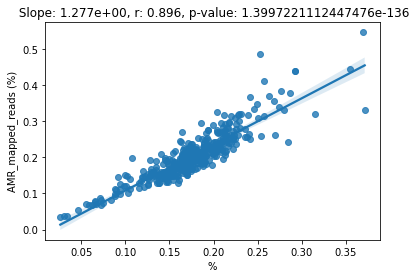

In [67]:
# sanity check of tight correlation between original AMR profiles and 
# MEGAres ontology mapped profiles
res = stats.linregress(megares_check_merged['%'],
                       megares_check_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=megares_check_merged)

In [68]:
megares_check_merged

,%,barcode_x,r1,r2,AMR_mapped_reads (%),primer_date,run_prefix,mastermix_lot,center_project_name,runid,...,katharoseq_log_cells,chao1,shannon,simpson,observed_features,faith_pd,shannon_median,observed_features_median,faith_pd_median,AMR_percent_median
sample_name,,,,,,,,,,,,,,,,,,,,,
14542.PMM1D1.R4,0.217693,3D0416A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.251801,20220120.0,3DMM_Plates_1-5_S1_L001,978215.0,3DMM,220608_M05314_0335_000000000-KF8F2,...,NaN,172.689655,3.588711,0.836408,143,6531.775222,3.970616,145.5,6800.279476,0.209911
14542.LAB1O6.R2,0.212256,3D0245A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.246881,20220120.0,3DMM_Plates_1-5_S1_L001,978215.0,3DMM,220608_M05314_0335_000000000-KF8F2,...,NaN,123.500000,3.890115,0.842961,116,5530.142192,4.347704,143.0,6565.807184,0.192426
14542.PMM1S1.L7,0.118796,3D1004A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.144828,20220120.0,3DMM_rerun_Plates_6-10_S1_L001,978215.0,3DMM,220622 M05314 0337 000000000-KF7HB,...,NaN,237.555556,4.430856,0.863327,194,8425.491542,3.970616,145.5,6800.279476,0.209911
14542.LAB1O2.L1,0.162383,3D0203A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.193943,20220120.0,3DMM_rerun_Plates_6-10_S1_L001,978215.0,3DMM,220622 M05314 0337 000000000-KF7HB,...,NaN,109.666667,4.408990,0.874095,108,5199.597244,4.347704,143.0,6565.807184,0.192426
14542.COL1A2.R1,0.131962,3D0492A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.148939,20220120.0,3DMM_Plates_1-5_S1_L001,978215.0,3DMM,220608_M05314_0335_000000000-KF8F2,...,NaN,94.500000,4.699455,0.934346,93,5072.790855,4.693390,129.0,6344.213699,0.162582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14542.NOD3A5.L1,0.229557,3D1356A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.281941,20220120.0,3DMM_Plates_1-5_S1_L001,978215.0,3DMM,220608_M05314_0335_000000000-KF8F2,...,NaN,264.363636,4.112642,0.816243,216,8397.118745,4.490239,181.0,7747.695654,0.213187
14542.LAB1S6.R2,0.117676,3D0207A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.133594,20220120.0,3DMM_rerun_Plates_6-10_S1_L001,978215.0,3DMM,220622 M05314 0337 000000000-KF7HB,...,NaN,154.875000,4.369536,0.853531,143,6426.989647,4.347704,143.0,6565.807184,0.192426
14542.LAB1O3.R1,0.191912,3D0248A,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,/qmounts/qiita_data/per_sample_FASTQ/194122/3D...,0.267792,20220120.0,3DMM_rerun_Plates_6-10_S1_L001,978215.0,3DMM,220622 M05314 0337 000000000-KF7HB,...,NaN,169.714286,3.473216,0.766932,138,6745.505174,4.347704,143.0,6565.807184,0.192426


In [69]:
MEGARES_taxonomy = Artifact.import_data('FeatureData[Taxonomy]', mapping_metadata[['Taxon']])

In [70]:
amr_megares_ft = Artifact.import_data('FeatureTable[Frequency]', amr_megares_mapped.fillna(0))

In [72]:
megares_mapped_genes = amr_megares_ft.view(pd.DataFrame).columns

In [74]:
amr_metadata_3dmm_df.head()

,ARO Accession,Reference Model Type,Reference DB,Resistomes & Variants: Observed Pathogen(s),AMR Gene Family,Drug Class,Resistance Mechanism
ARO Term,,,,,,,
srmB,3002828,protein homolog model,CARD,Streptomyces ambofaciens,Miscellaneous ABC-F subfamily ATP-binding cass...,macrolide antibiotic,antibiotic target protection
vgaALC,3002830,protein homolog model,CARD; Resistomes & Variants,Staphylococcus haemolyticus; Enterobacter horm...,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection
mtrE,3000812,protein homolog model,CARD,Neisseria gonorrhoeae,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; penam,antibiotic efflux
macB,3000535,protein homolog model,CARD; Resistomes & Variants,Neisseria gonorrhoeae,ATP-binding cassette (ABC) antibiotic efflux pump,macrolide antibiotic,antibiotic efflux
vgaA,3002829,protein homolog model,CARD,Staphylococcus aureus,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection


In [76]:
amr_metadata_3dmm_df.loc[amr_metadata_3dmm_df['ARO Accession'].isin(megares_mapped_genes)]['Reference DB'].value_counts()

Resistomes & Variants          412
CARD                           212
CARD; Resistomes & Variants     66
Name: Reference DB, dtype: int64

In [85]:
amr_megares_ft_class_collpased = taxa.methods.collapse(amr_megares_ft,MEGARES_taxonomy,1).collapsed_table

In [86]:
collapsed_megares_check = pd.DataFrame(amr_megares_ft_class_collpased.view(pd.DataFrame).sum(1),columns=['%'])

In [87]:
collapsed_megares_check_merged = collapsed_megares_check.merge(files_3dmm_merged,left_index=True, right_on='sample_name')
collapsed_megares_check_merged['%'] = collapsed_megares_check_merged['%'] * 100 #to turn into %

<AxesSubplot:title={'center':' Slope: 1.277e+00, r: 0.896, p-value: 1.3997221112442697e-136'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

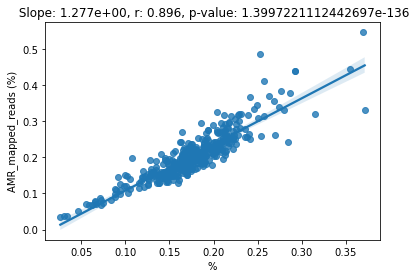

In [88]:
# sanity check of tight correlation between original AMR profiles and 
# MEGAres ontology mapped profiles, collapsed at AMR class
res = stats.linregress(collapsed_megares_check_merged['%'],
                       collapsed_megares_check_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=collapsed_megares_check_merged)

In [89]:
plot_data = np.log10(amr_megares_ft_class_collpased.view(pd.DataFrame)).melt(var_name='AMR Class',
                                                                        value_name='RelativeAbundance')
plot_data = plot_data.replace(-np.inf,np.nan)

/tmp/ipykernel_1949/292597032.py:1: RuntimeWarning: divide by zero encountered in log10
  plot_data = np.log10(amr_megares_ft_class_collpased.view(pd.DataFrame)).melt(var_name='AMR Class',


In [90]:
for class_ in plot_data['AMR Class'].unique():
    median_ = plot_data.loc[plot_data['AMR Class']==class_,'RelativeAbundance'].median()
    denom_ = plot_data.loc[plot_data['AMR Class']==class_].shape[0]
    prevalence_ = sum(~plot_data.loc[plot_data['AMR Class']==class_,'RelativeAbundance'].isnull())/denom_
    plot_data.loc[plot_data['AMR Class']==class_,'median_ra']=median_
    plot_data.loc[plot_data['AMR Class']==class_,'prevalence']=prevalence_

In [91]:
plot_data.sort_values(by=['prevalence','median_ra'])['AMR Class'].unique()

array(['Thiopeptides', 'Elfamycins', 'Fusidic_acid', 'Aminocoumarins',
       'Sulfonamides', 'Nucleosides', 'Trimethoprim', 'Fluoroquinolones',
       'Phenicol', 'betalactams', 'Tetracyclines',
       'Phenolic_compound_resistance', 'Mupirocin', 'Fosfomycin', 'MLS',
       'Cationic_antimicrobial_peptides', 'Lipopeptides',
       'Aminoglycosides', 'Drug_and_biocide_resistance',
       'Multi-drug_resistance', 'Glycopeptides', 'Rifampin'], dtype=object)

/home/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


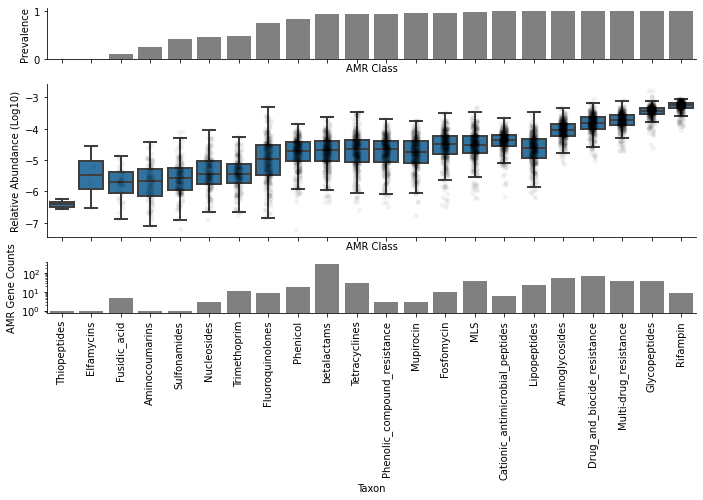

In [92]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(10,5),gridspec_kw={'height_ratios': [1,3, 1]})
sns.barplot(x='AMR Class',y='prevalence',data=plot_data.sort_values(by=['prevalence','median_ra']),
            ax=ax1,color='gray')
sns.stripplot(x='AMR Class',y='RelativeAbundance',data=plot_data.sort_values(by=['prevalence','median_ra']),
              alpha=0.05,color='black',ax=ax2)
sns.boxplot(x='AMR Class',y='RelativeAbundance',data=plot_data.sort_values(by=['prevalence','median_ra'])
            ,color='tab:blue',linewidth=2,ax=ax2,fliersize=0)
sns.countplot(mapping_metadata.loc[mapping_metadata.index.isin(amr_megares_mapped.columns)]['Taxon'],ax=ax3,
              order=plot_data.sort_values(by=['prevalence','median_ra'])['AMR Class'].unique(),color='gray')
ax3.set_yscale('log')
ax2.set_ylabel('Relative Abundance (Log10)')
ax1.set_ylabel('Prevalence')
ax3.set_ylabel('AMR Gene Counts')
for axes in [ax1,ax2,ax3]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('./figs/AMR_class.svg')

In [93]:
plot_data.groupby('AMR Class').median().sort_values(by='prevalence')


,RelativeAbundance,median_ra,prevalence
AMR Class,,,
Thiopeptides,-6.410744,-6.410744,0.005089
Elfamycins,-5.472797,-5.472797,0.010178
Fusidic_acid,-5.710169,-5.710169,0.101781
Aminocoumarins,-5.663697,-5.663697,0.251908
Sulfonamides,-5.581597,-5.581597,0.422392
Nucleosides,-5.443940,-5.443940,0.447837
Trimethoprim,-5.436186,-5.436186,0.483461
Fluoroquinolones,-4.964394,-4.964394,0.753181
Phenicol,-4.700475,-4.700475,0.832061


In [94]:
mapping_metadata.loc[mapping_metadata.index.isin(amr_megares_mapped.columns)]['Taxon'].nunique()

22

In [95]:
AMR_per_module_df = pd.DataFrame(index=metadata_w_alpha['module'].unique())
for module in metadata_w_alpha['module'].unique():
    samples_in_module = metadata_w_alpha.loc[metadata_w_alpha['module']==module].index
    subset_ft = amr_3dmm_ft.loc[amr_3dmm_ft.index.isin(samples_in_module)]
    AMR_genes_n = sum(subset_ft.sum()>0)
    AMR_per_module_df.loc[module,'AMR gene count']=AMR_genes_n


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.681e-01 U_stat=7.930e+02
Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.459e-01 U_stat=3.312e+03
JLP vs. JPM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.059e-05 U_stat=9.200e+01
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.030e-01 U_stat=2.644e+03
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.690e-01 U_stat=6.490e+02
Node 1 vs. Airlock: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.198e-01 U_stat=1.680e+02
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochber

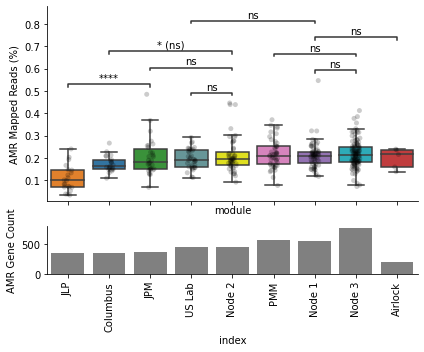

In [96]:
order_ = collapsed_megares_check_merged.sort_values(by='AMR_percent_median')['module'].unique()
#pairs were defined by physical interconnectedness of modules 

f, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(6,5),gridspec_kw={'height_ratios': [4,1]})


sns.boxplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),fliersize=0,ax=ax1,
           palette=module_colors)
sns.stripplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),color='black',alpha=0.2,ax=ax1)
plt.xticks(rotation=90)

# ax1.set_ylim(0,0.7)
pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=files_3dmm_merged, x='module', y='AMR_mapped_reads (%)', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

sns.barplot(x='index',y='AMR gene count',data=AMR_per_module_df.reset_index(),ax=ax2,
              order=collapsed_megares_check_merged.sort_values(by=['AMR_percent_median'])['module'].unique(),color='gray')

for axes in [ax1,ax2]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

ax2.set_ylabel('AMR Gene Count')
ax1.set_ylabel('AMR Mapped Reads (%)')
plt.tight_layout()
plt.savefig('./figs/AMR_per_module.svg')

In [97]:
amr_metadata_3dmm_df['Reference DB'].value_counts()

Resistomes & Variants          625
CARD                           340
CARD; Resistomes & Variants    100
Name: Reference DB, dtype: int64

# MAG AMR

In [77]:
pantoea_amr = pd.read_csv('./data/pantoea_amr.txt',sep='\t')

In [78]:
pantoea_amr['Specifics'].unique()

array(['ISS-Internal Surface', 'Urban', 'Saliva', 'Urine', 'Blood'],
      dtype=object)

In [79]:
amr_counts_df = pd.DataFrame(index=pantoea_amr['Bin.ID'].unique())
for genome_ in pantoea_amr['Bin.ID'].unique():
    AMR_gene_count = pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Protein.identifier'].nunique()
    amr_counts_df.loc[genome_,'AMR gene count']=AMR_gene_count
    amr_counts_df.loc[genome_,'category']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Category'].unique()
    amr_counts_df.loc[genome_,'source']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Source'].unique()
    amr_counts_df.loc[genome_,'Specifics']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Specifics'].unique()
    

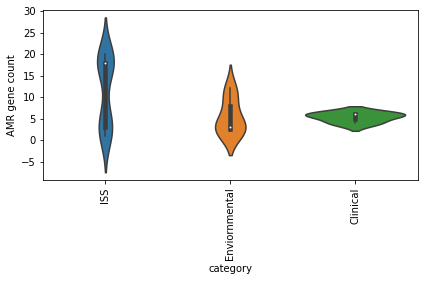

In [80]:
sns.violinplot(x='category',y='AMR gene count',data=amr_counts_df)
plt.xticks(rotation=90)

plt.tight_layout()

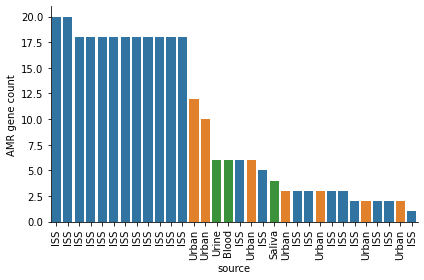

In [81]:
amr_counts_df.loc[amr_counts_df['Specifics']=='ISS-Internal Surface','Specifics']='ISS'
fig, ax = plt.subplots()

lut = dict(zip(amr_counts_df['category'].unique(),
               sns.color_palette("tab10",n_colors=3)))
col_colors = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['category'].map(lut)

sns.barplot(x='index',y='AMR gene count',data=amr_counts_df.sort_values(by='AMR gene count',ascending=False).reset_index(),palette=col_colors)
labels_ = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['Specifics']
ticks = ax.get_xticks().tolist()
plt.xticks(rotation=90,ticks=ticks,labels=labels_)
plt.tight_layout()
plt.xlabel('source')

for axes in [ax]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

plt.savefig('./figs/amr_gene_counts_pantoea_comparison.svg')

/tmp/ipykernel_49253/215415535.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


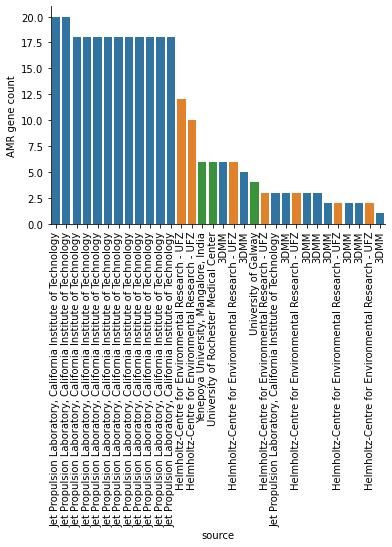

In [82]:
fig, ax = plt.subplots()

lut = dict(zip(amr_counts_df['category'].unique(),
               sns.color_palette("tab10",n_colors=3)))
col_colors = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['category'].map(lut)

sns.barplot(x='index',y='AMR gene count',data=amr_counts_df.sort_values(by='AMR gene count',ascending=False).reset_index(),palette=col_colors)
labels_ = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['source']
ticks = ax.get_xticks().tolist()
plt.xticks(rotation=90,ticks=ticks,labels=labels_)
plt.tight_layout()
plt.xlabel('source')

for axes in [ax]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

In [83]:
from matplotlib_venn import venn3, venn3_circles

In [84]:
env_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='Enviornmental']['Gene.symbol'])
clin_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='Clinical']['Gene.symbol'])
iss_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='ISS']['Gene.symbol'])

/home/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


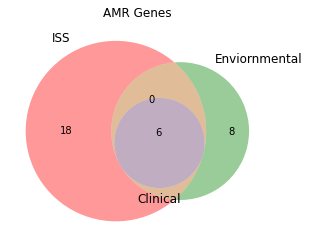

In [85]:
venn3([iss_amr_genes,env_amr_genes,clin_amr_genes],set_labels=['ISS','Enviornmental','Clinical'])
plt.title('AMR Genes')
plt.savefig('./figs/amr_venn.svg')

In [86]:
iss_amr_genes-env_amr_genes

{'arsB',
 'blaOXA',
 'erm(C)',
 'fosB',
 'merA',
 'mupA',
 'pcoA',
 'pcoB',
 'pcoC',
 'pcoD',
 'pcoE',
 'pcoR',
 'pcoS',
 'silB',
 'silC',
 'silE',
 'silF',
 'silS'}

In [ ]:
MUPIROCIN
FOSFOMYCIN
betalactams